<img style="float:right" src="images/logo_va.png" /> 

# Visione Artificiale
## Esercitazione: Filtri

### Sommario
* Creare filtri per simulare "motion blur"
* Filtro "emboss"
* Individuare un bordo e stimare la sua orientazione in ciascun punto
* Creare un'immagine "ibrida"

Iniziamo con l'importazione dei moduli che ci serviranno: `NumPy`, `OpenCV`, `va`. Importiamo anche il modulo `math` e la funzione `interact` di Jupyter.

In [3]:
import numpy as np
import cv2 as cv
import va
import math
from ipywidgets import interact

A lezione abbiamo osservato l'effetto dei filtri di smooth: in particolare abbiamo considerato il box filter e il filtro gaussiano. Vediamo ora un filtro che produce un altro tipo di blur.

In [5]:
f = np.eye(7)
print(f)

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


Abbiamo utilizzato la funzione `identity` di NumPy per ottenere una matrice identità di ordine 7. La useremo come filtro, dopo averne normalizzato i valori dividendoli per la loro somma.  
Si noti che nella funzione `cv.filter2D` passiamo -1 al parametro `ddepth` in modo da ottenere un risultato con lo stesso tipo di pixel dell'immagine di partenza: essendo il filtro composto da valori solo positivi e normalizzati (somma 1), non ci saranno problemi. Si ricordi inoltre che, nel caso di immagini a più canali (l'immagine nell'esempio è a colori BGR), `cv.filter2D` applica semplicemente lo stesso filtro a ciascun canale.

,
,

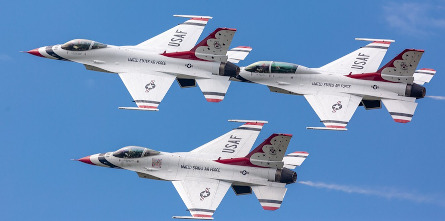
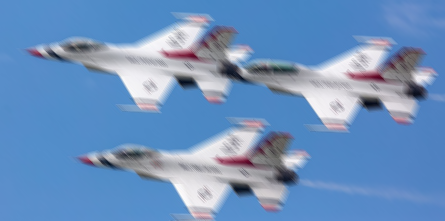

In [6]:
f/=f.sum()
img = cv.imread('filtri/thunderbirds.jpg')
res = cv.filter2D(img, -1, f)
va.show(img, res)

Il risultato ottenuto è un *motion blur*: una sfocatura lungo una certa orientazione (in questo caso la diagonale della matrice filtro), che ricorda una foto scattata a oggetti in movimento con tempo di esposizione troppo lungo.  
Proviamo ora a generalizzare la costruzione di tale filtro per una qualsiasi orientazione.

<img style="float:left" src="images/ar.png" />**Esercizio 1** - Nella prossima cella completare la funzione che crea un filtro quadrato con dimensione `size` con tutti i coefficienti pari a zero tranne quelli situati lungo una linea (passante per il centro del filtro) orientata in base all'angolo `angle` (espresso in gradi). Tali valori dovranno essere positivi, uguali fra loro e con somma 1 (filtro normalizzato).  
Suggerimenti: serviranno probabilmente alcune funzioni trigonometriche che potete trovare nel modulo Python `math`; per modificare i valori lungo la linea, un modo semplice può essere considerare il filtro come un'immagine (di float) e utilizzare un'apposita funzione OpenCV...  
La cella seguente, una volta eseguita, crea una serie di filtri (con varie dimensioni e angoli) con la `create_motion_blur_filter`; quindi visualizza ciascun filtro con a fianco il filtro atteso, caricato da file. Se i filtri sono sufficientemente simili a quelli attesi si può proseguire.

In [31]:
def create_motion_blur_filter(size=7, angle=0):    
    
    f = np.zeros((size, size))
    
    # --- Svolgimento Esercizio 1: Inizio --- #
    a = math.radians(angle)
    r= size//2
    dx, dy= round(math.cos(a)*r*1.5), round(math.sin(a)*r*1.5)
    cv.line(f, (r+dx, r+dy), (r-dx, r-dy), 1)
    f/=f.sum()
    
    # --- Svolgimento Esercizio 1: Fine --- #
    
    return f

"s=3,a=0°",(Verifica),"s=3,a=15°",(Verifica),"s=3,a=30°",(Verifica),"s=3,a=45°",(Verifica),"s=3,a=60°",(Verifica),"s=3,a=75°",(Verifica)
,,,,,,,,,,,
"s=3,a=90°",(Verifica),"s=3,a=105°",(Verifica),"s=3,a=120°",(Verifica),"s=3,a=135°",(Verifica),"s=3,a=150°",(Verifica),"s=3,a=165°",(Verifica)
,,,,,,,,,,,
"s=5,a=0°",(Verifica),"s=5,a=15°",(Verifica),"s=5,a=30°",(Verifica),"s=5,a=45°",(Verifica),"s=5,a=60°",(Verifica),"s=5,a=75°",(Verifica)
,,,,,,,,,,,
"s=5,a=90°",(Verifica),"s=5,a=105°",(Verifica),"s=5,a=120°",(Verifica),"s=5,a=135°",(Verifica),"s=5,a=150°",(Verifica),"s=5,a=165°",(Verifica)
,,,,,,,,,,,
"s=7,a=0°",(Verifica),"s=7,a=15°",(Verifica),"s=7,a=30°",(Verifica),"s=7,a=45°",(Verifica),"s=7,a=60°",(Verifica),"s=7,a=75°",(Verifica)
,,,,,,,,,,,
"s=7,a=90°",(Verifica),"s=7,a=105°",(Verifica),"s=7,a=120°",(Verifica),"s=7,a=135°",(Verifica),"s=7,a=150°",(Verifica),"s=7,a=165°",(Verifica)

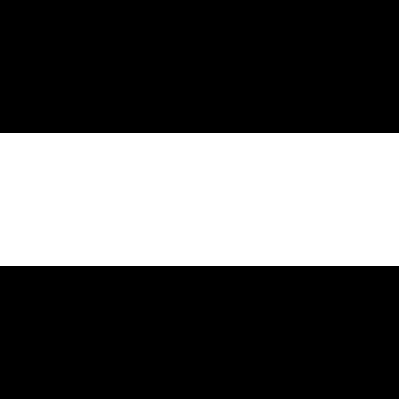
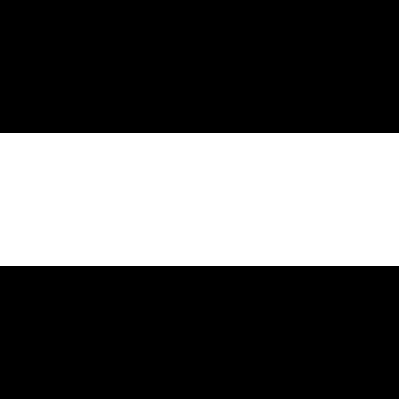
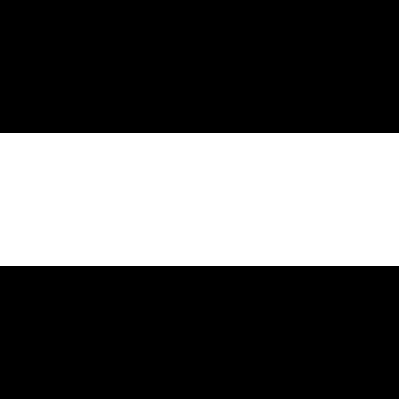
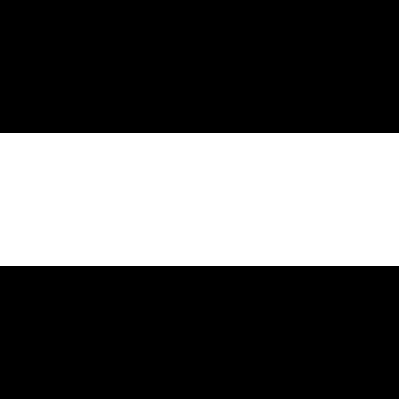
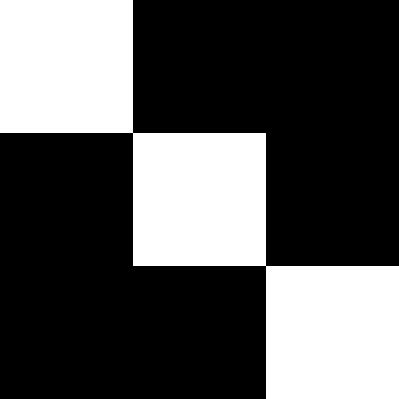
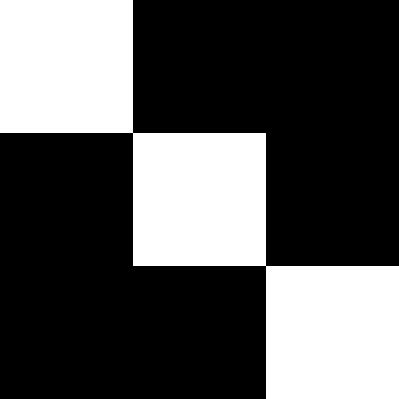
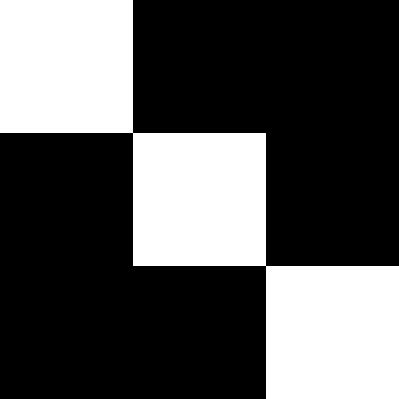
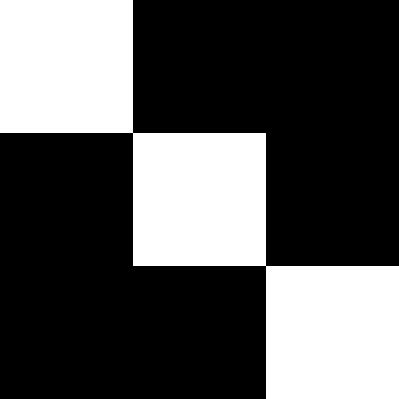
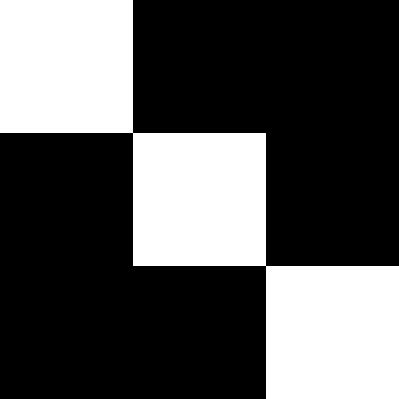
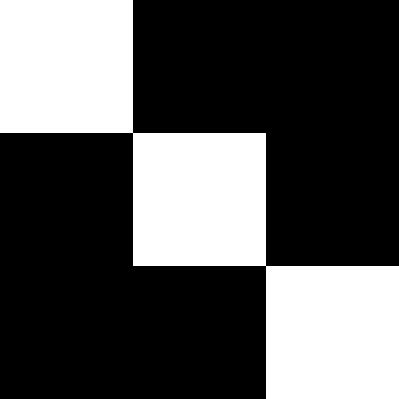
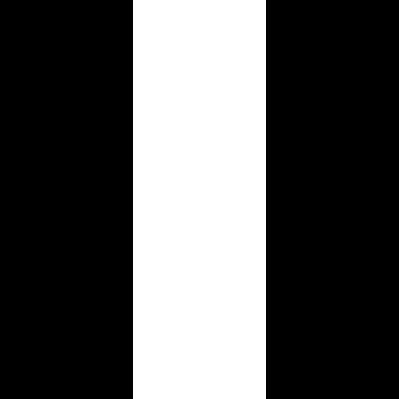
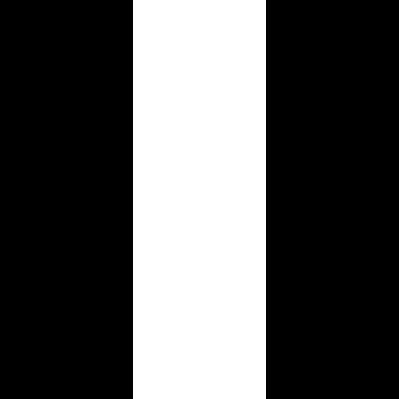
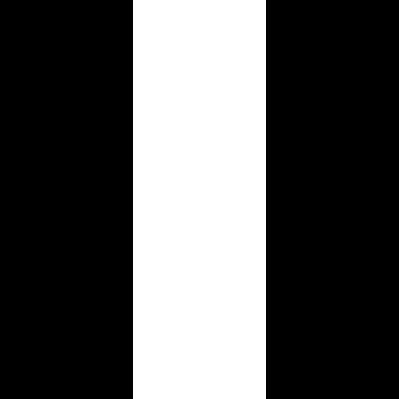
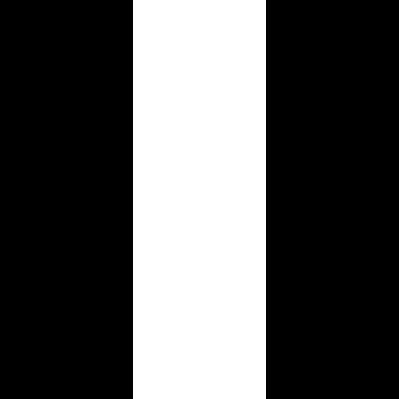
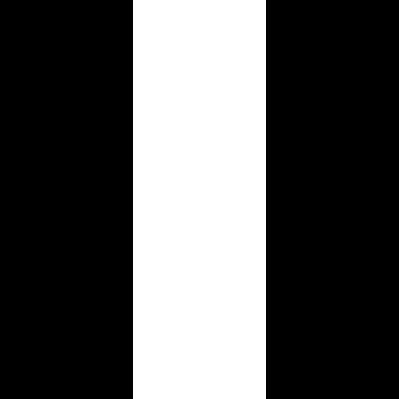
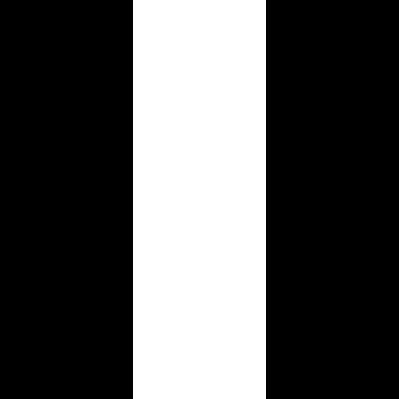
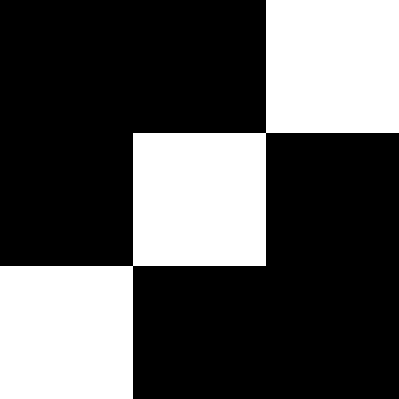
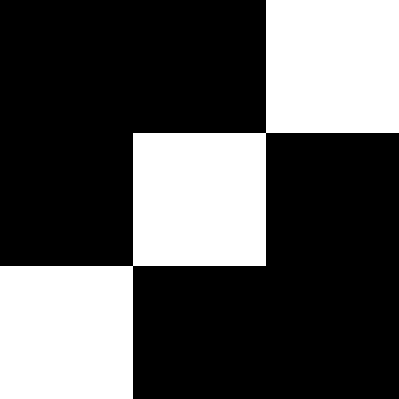
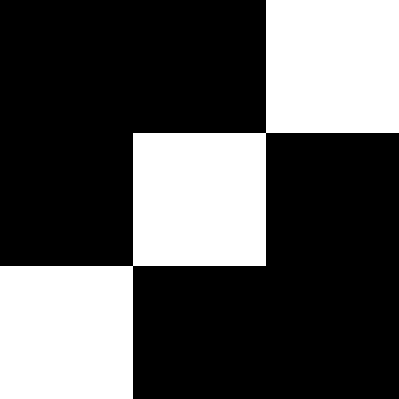
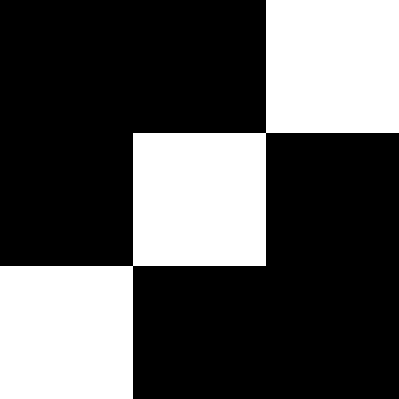
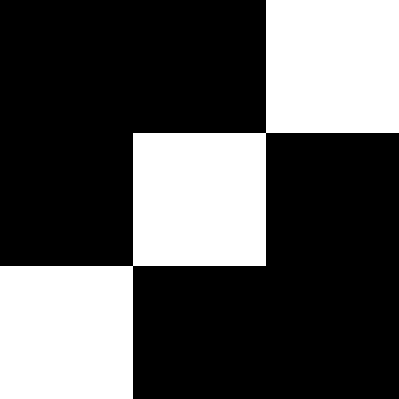
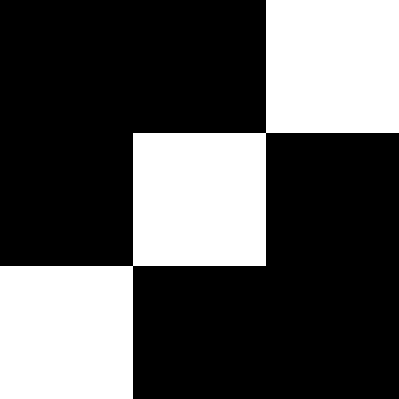
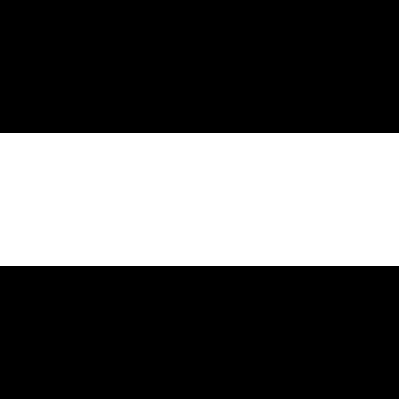
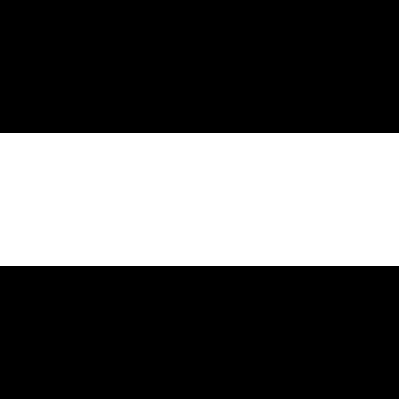
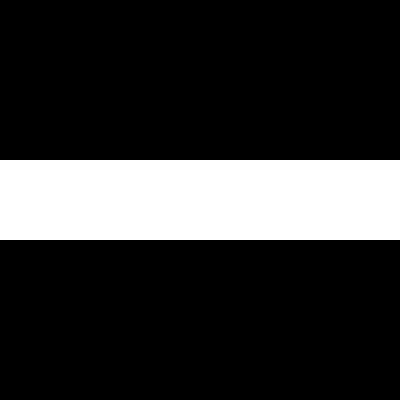
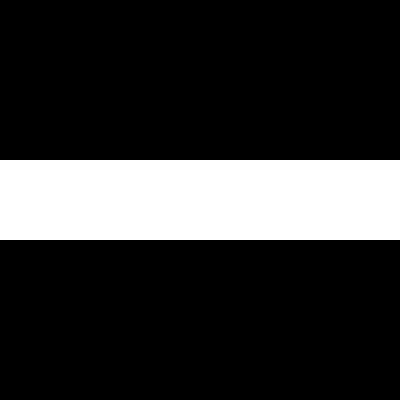
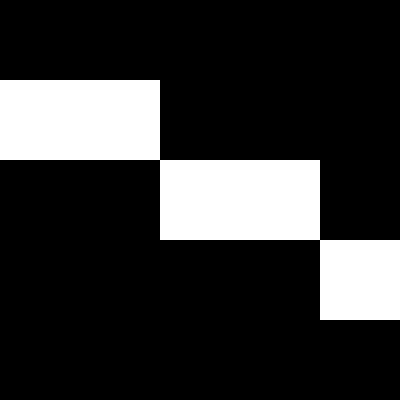
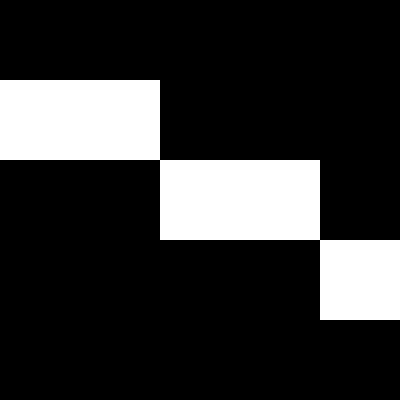
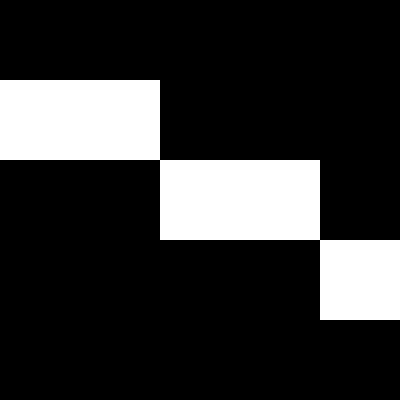
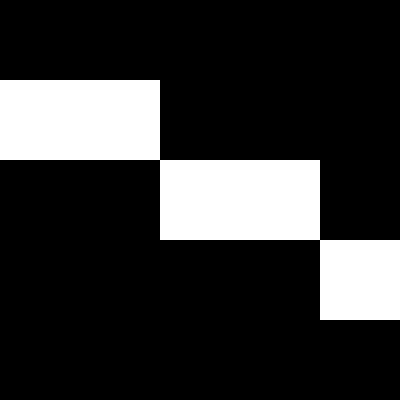
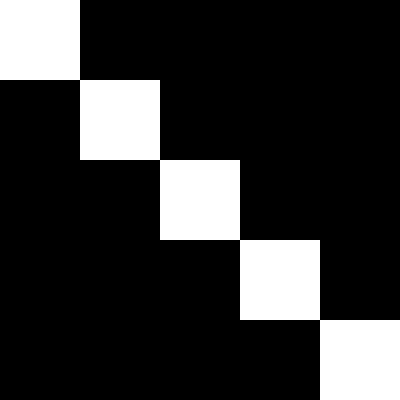
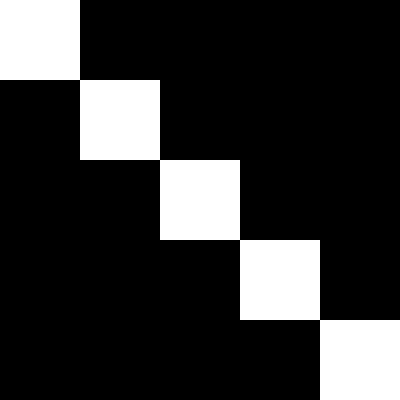
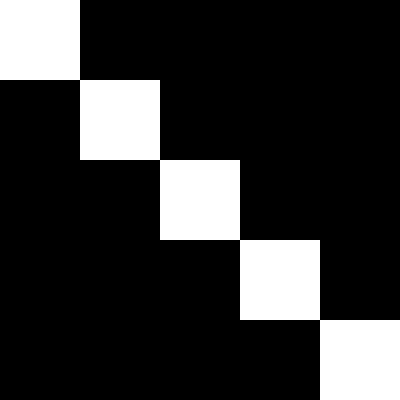
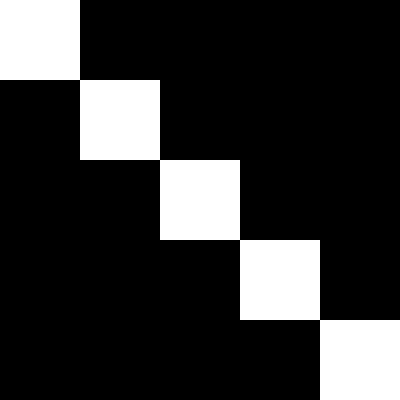
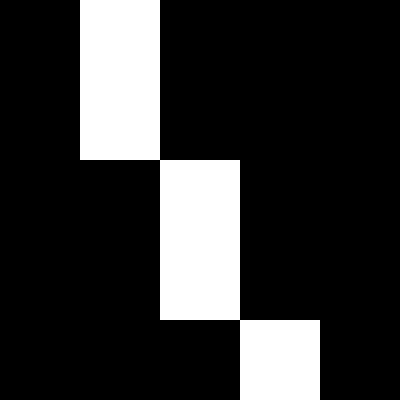
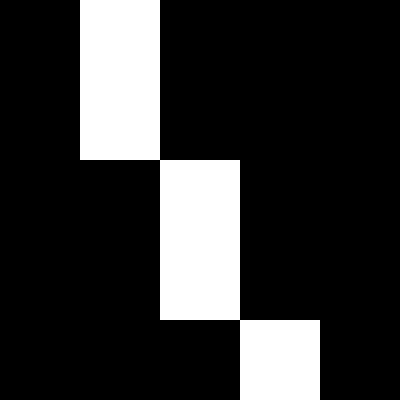
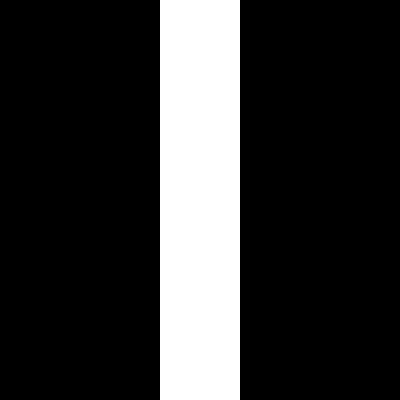
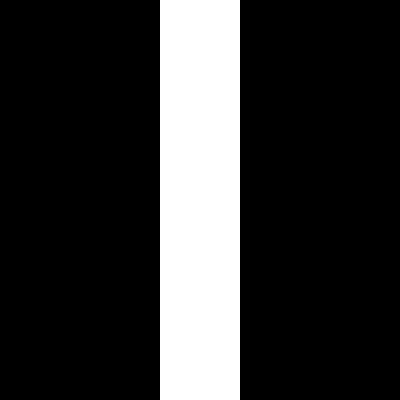
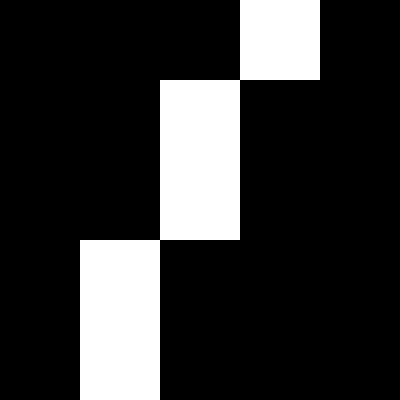
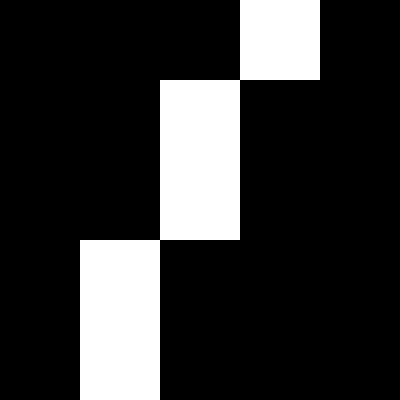
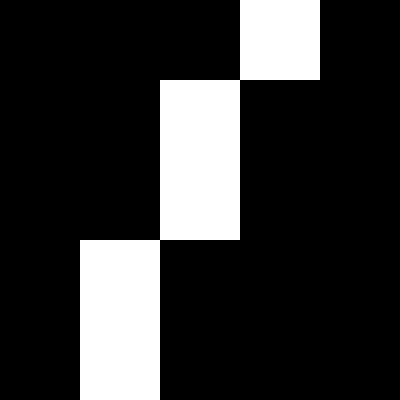
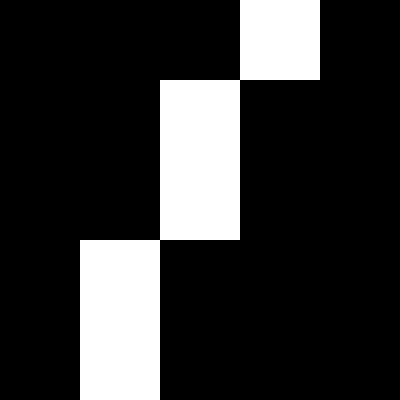
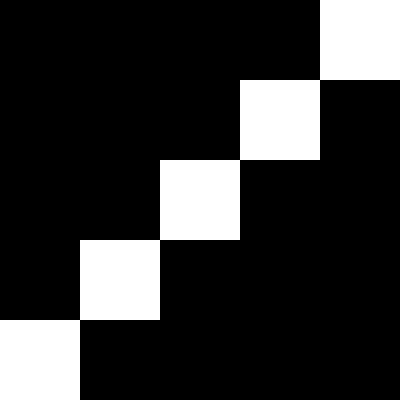
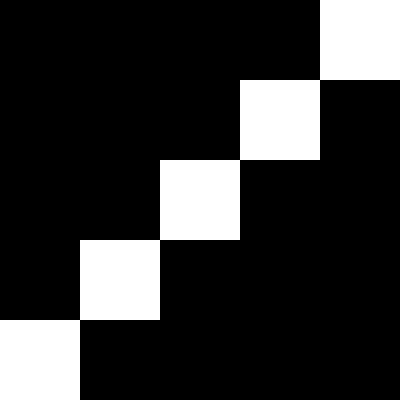
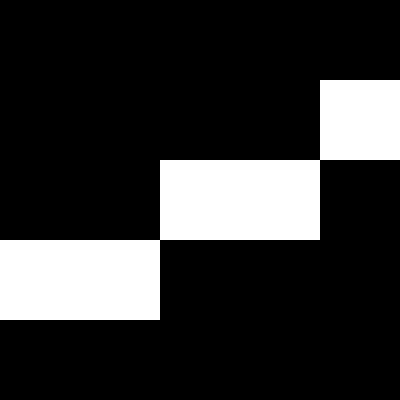
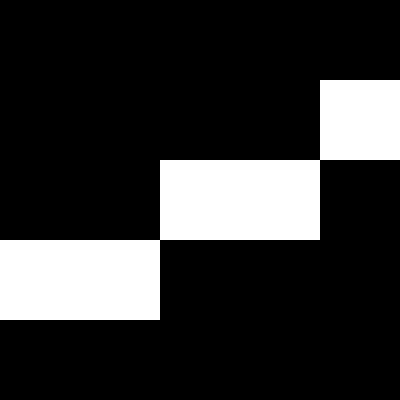
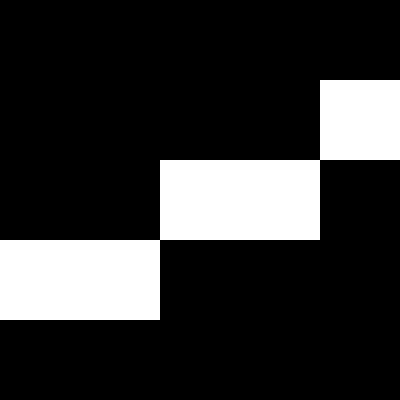
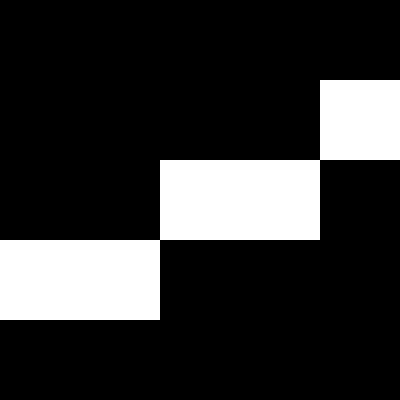
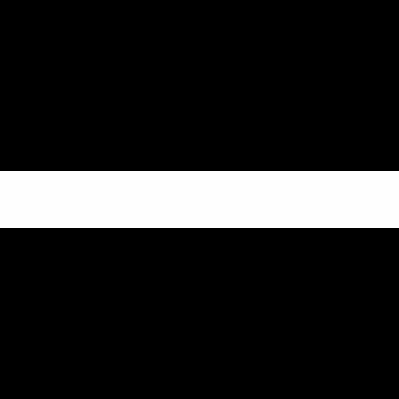
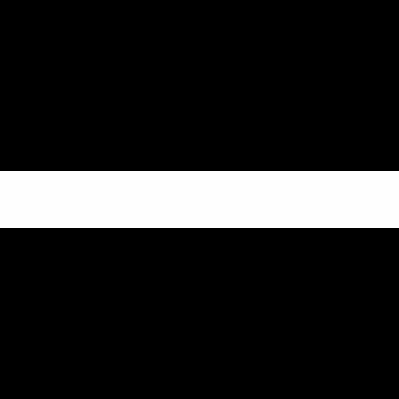
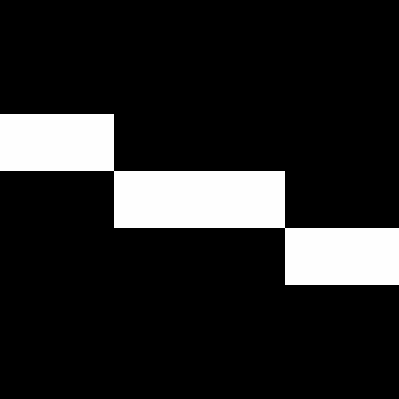
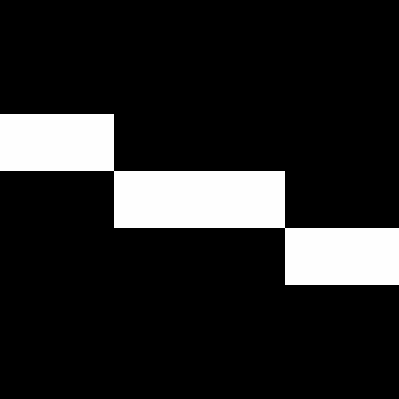
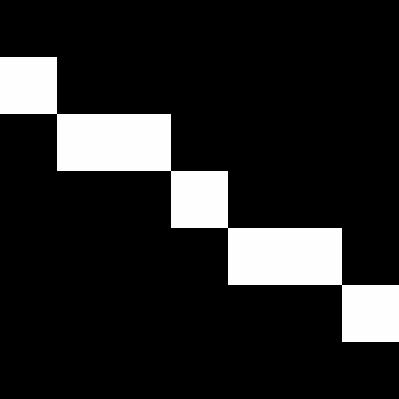
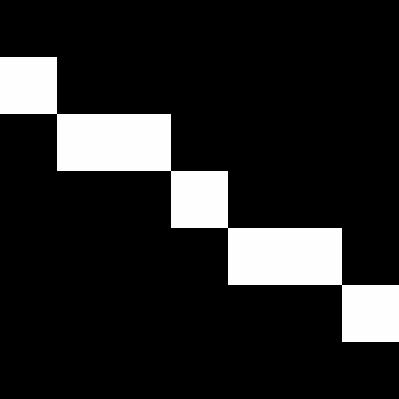
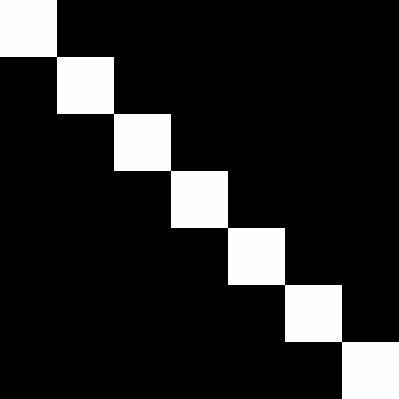
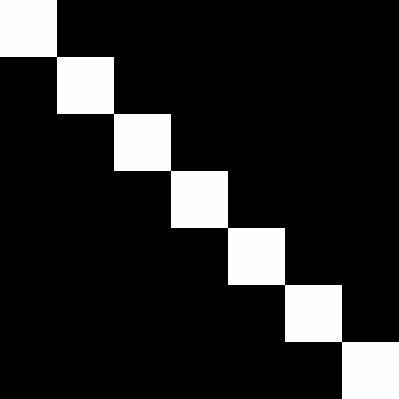
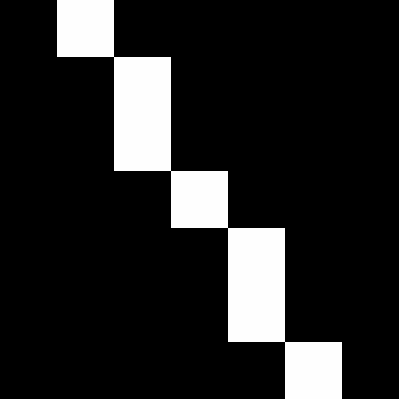
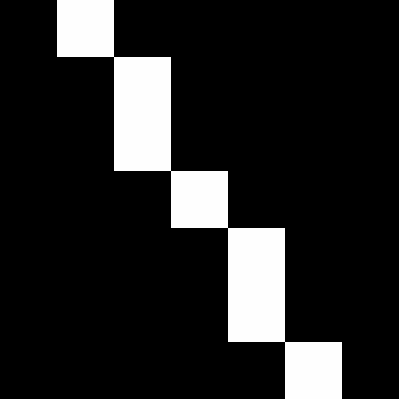
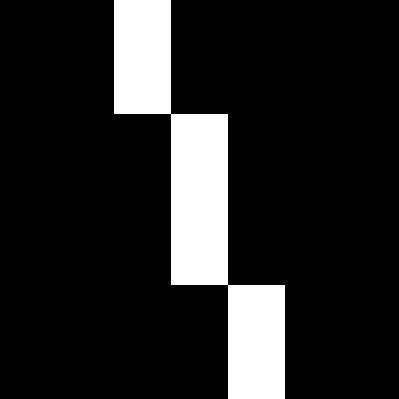
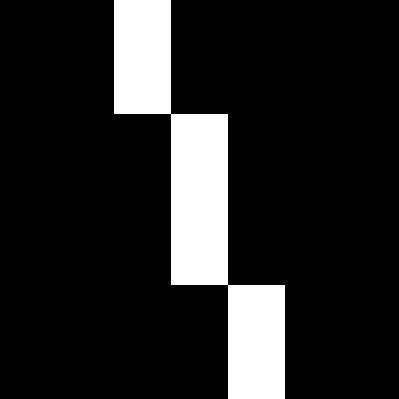
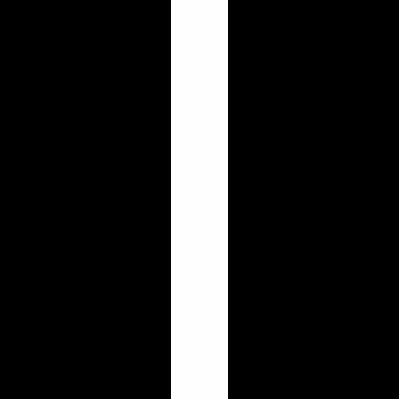
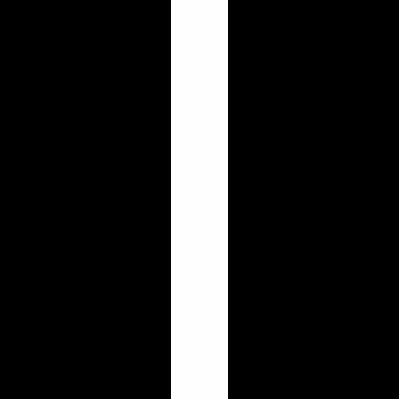
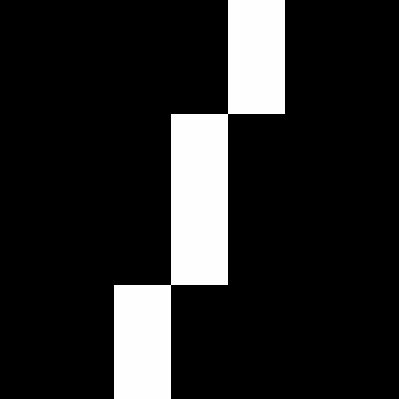
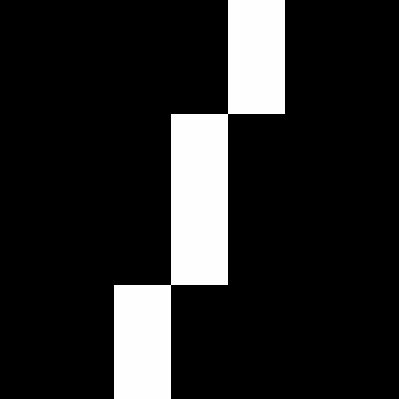
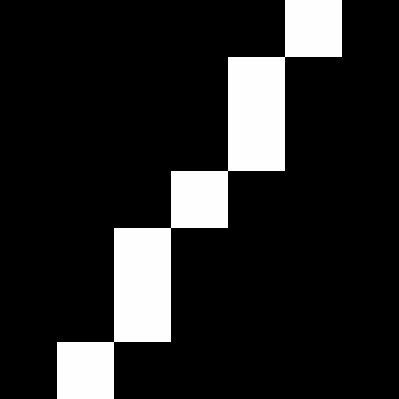
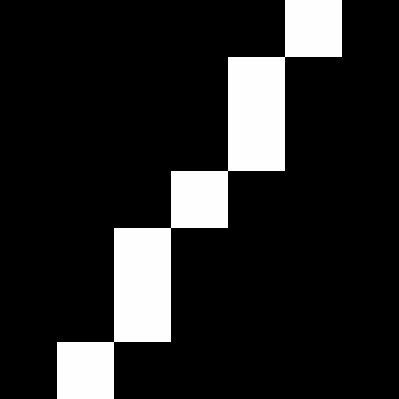
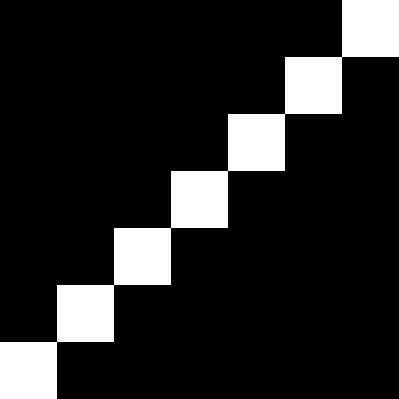
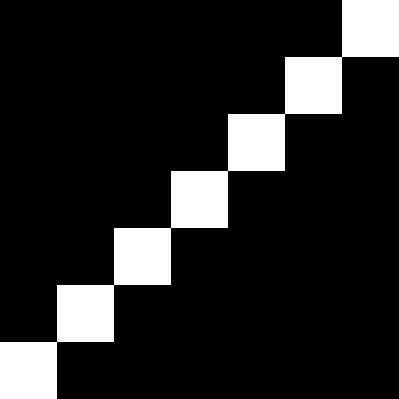
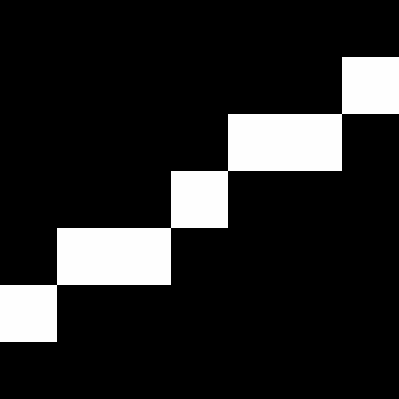
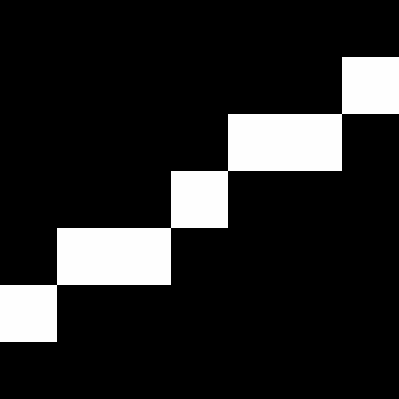
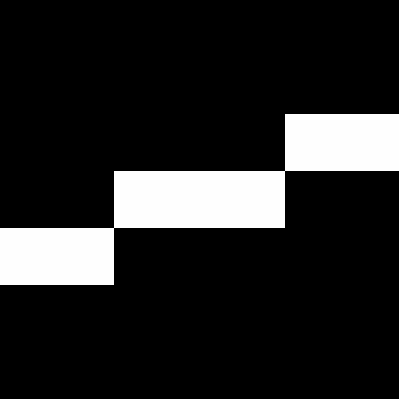
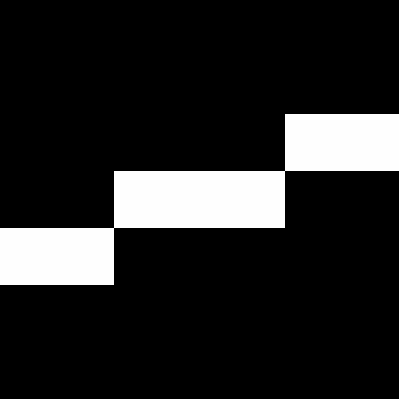
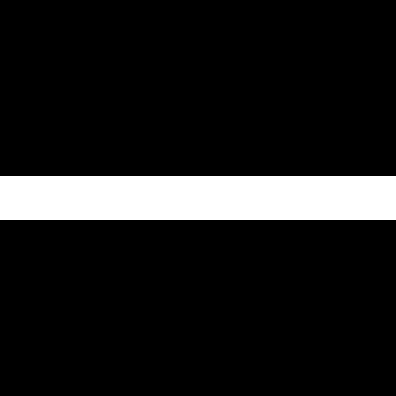
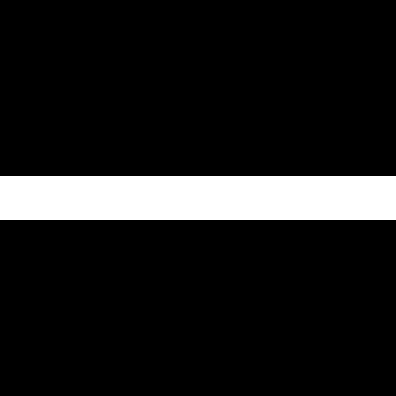
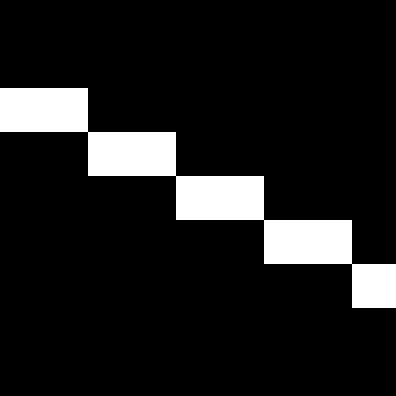
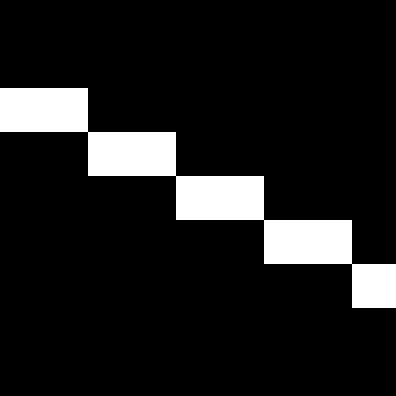
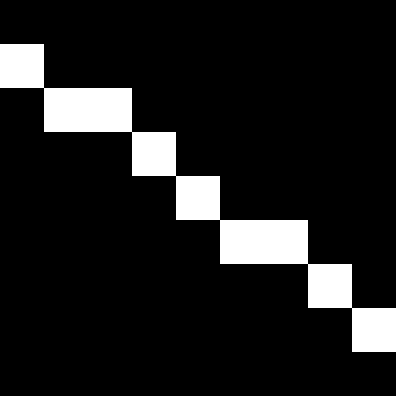
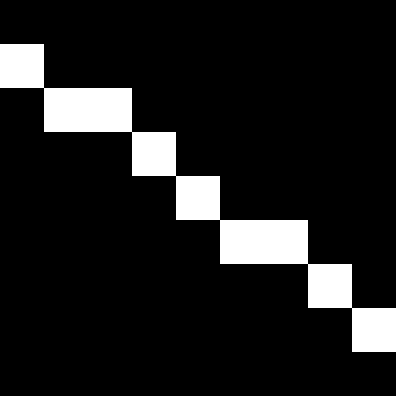
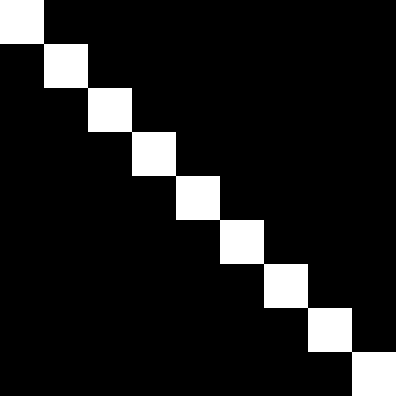
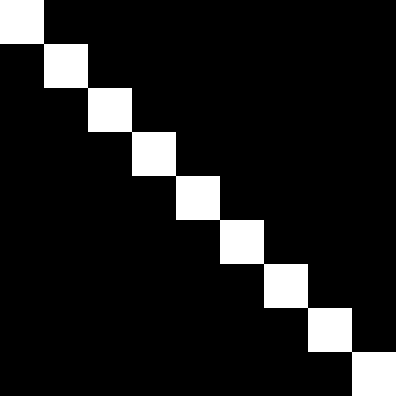
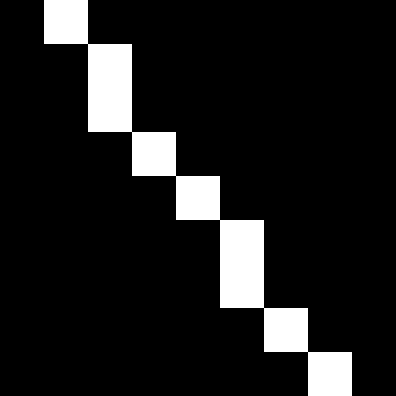
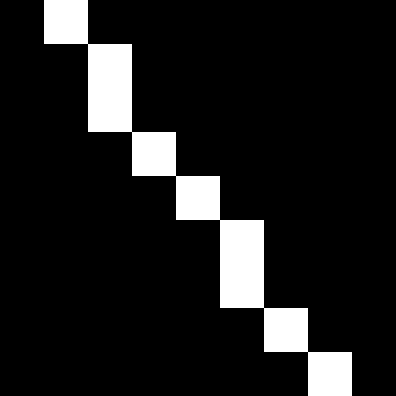
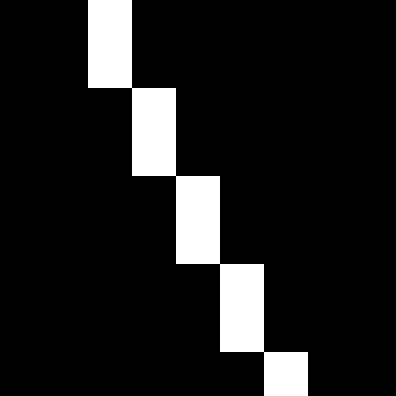
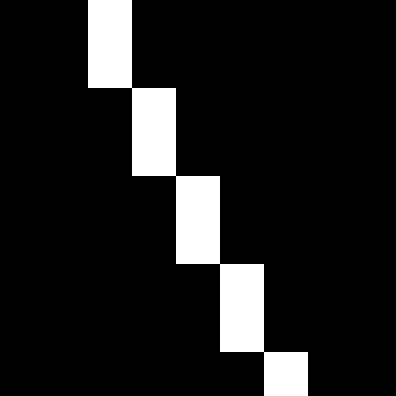
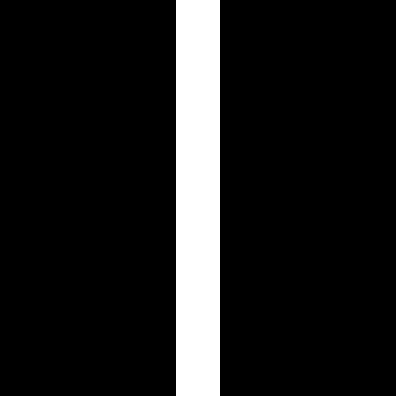
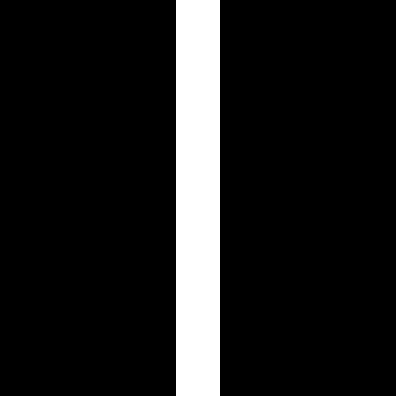
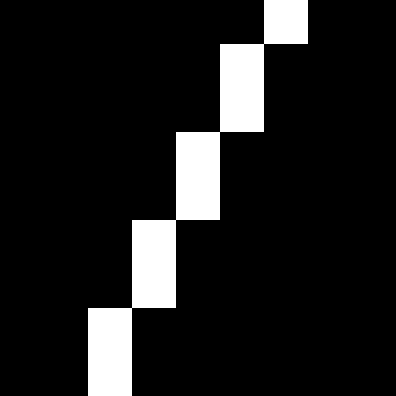
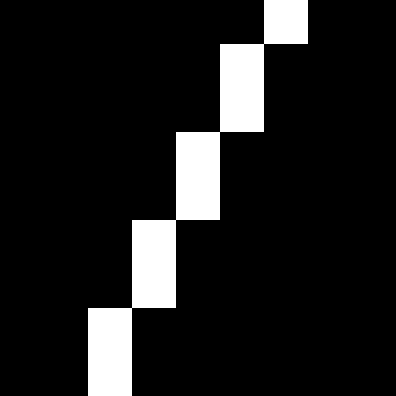
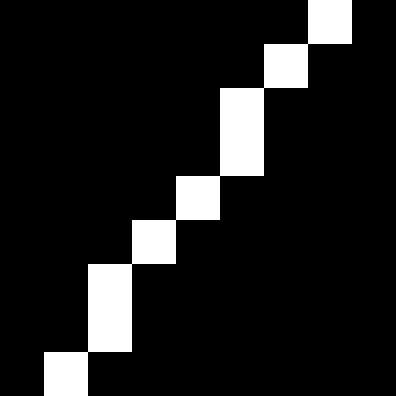
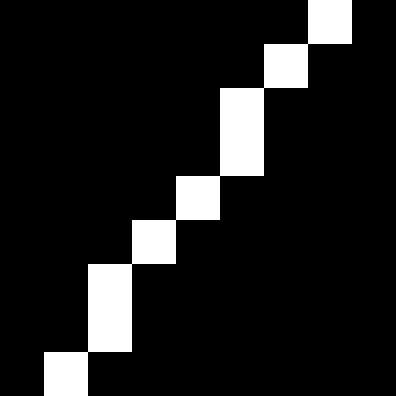
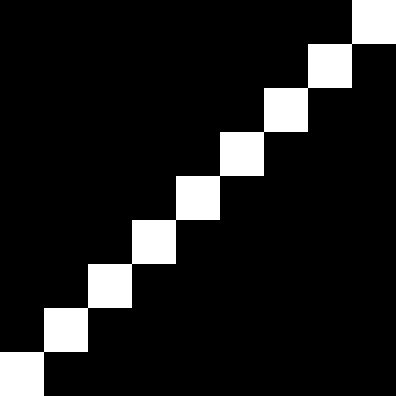
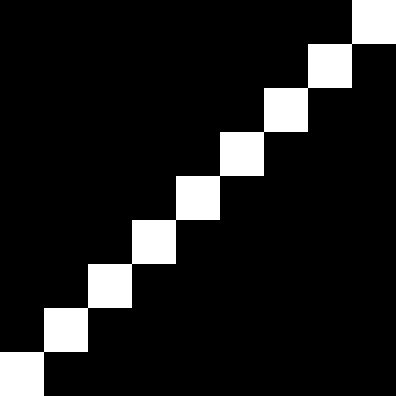
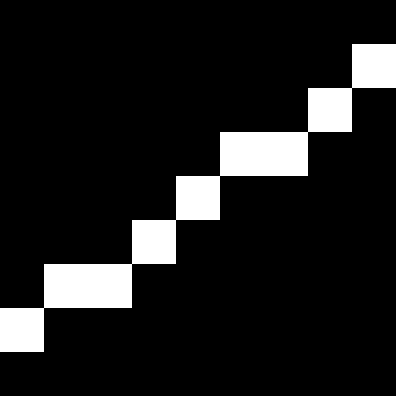
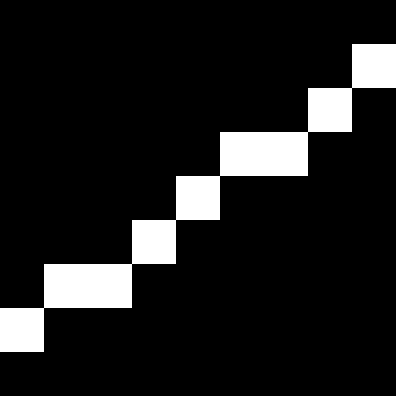
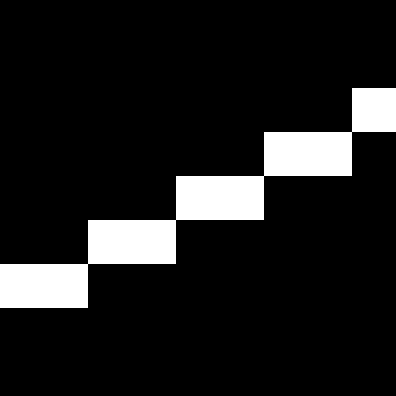
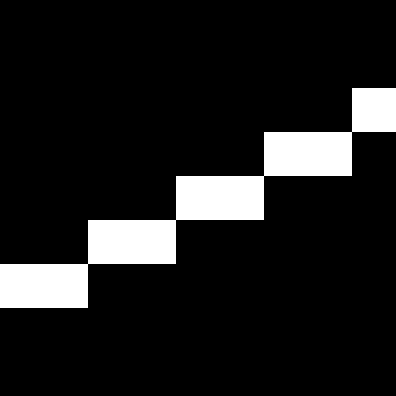
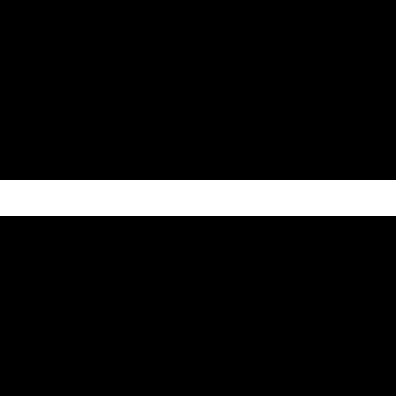
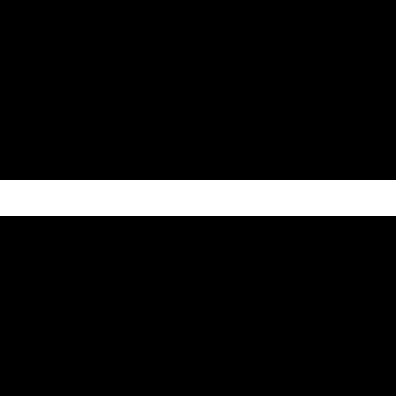
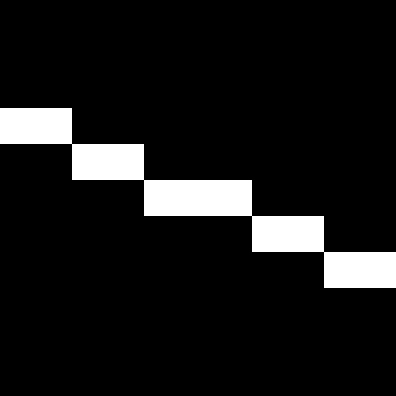
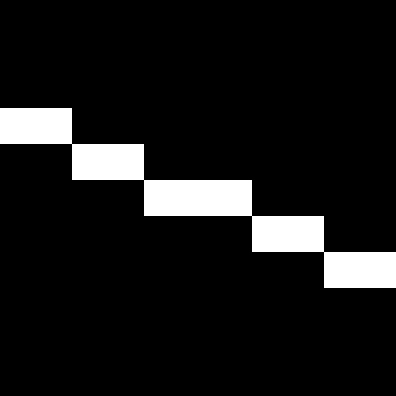
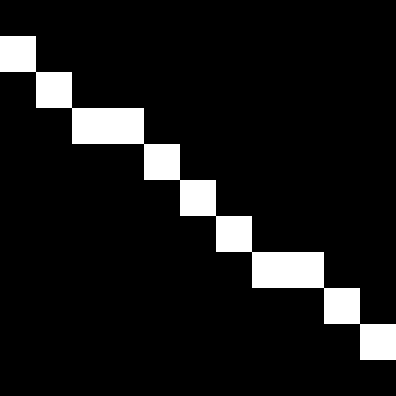
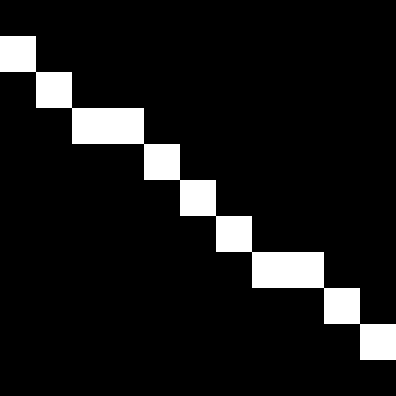
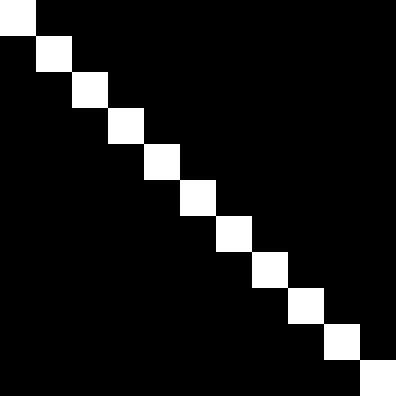
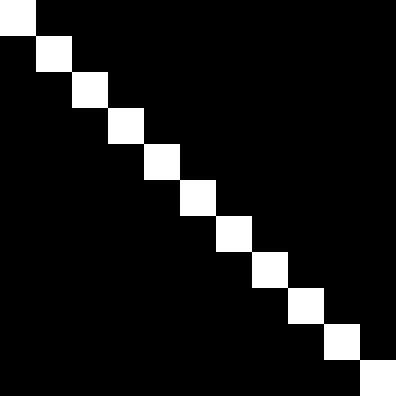
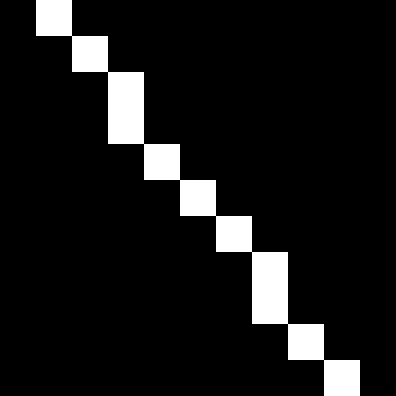
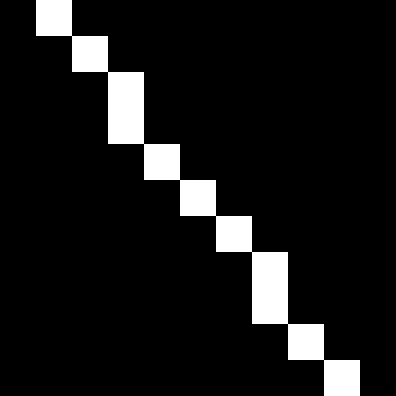
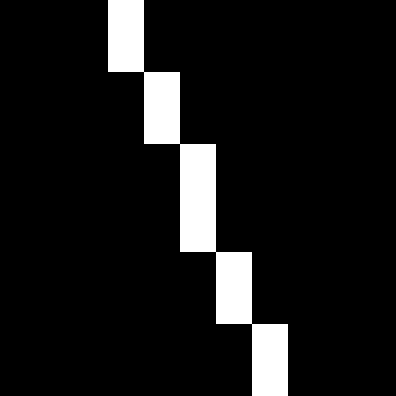
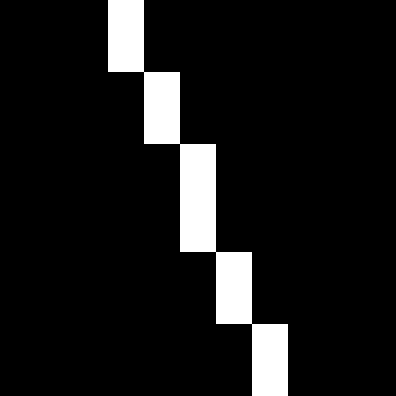
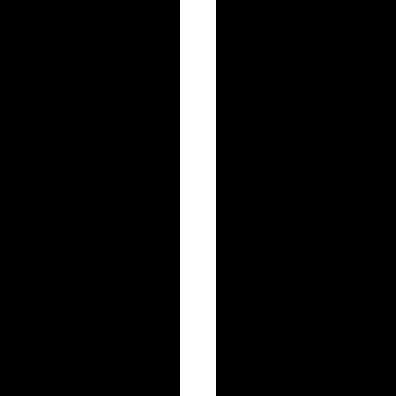
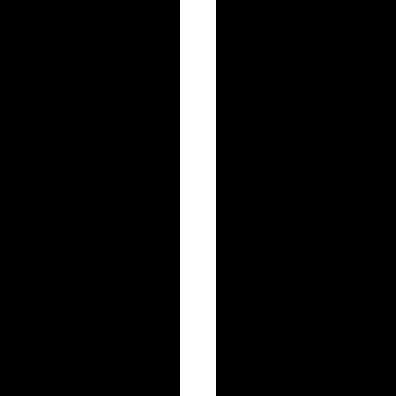
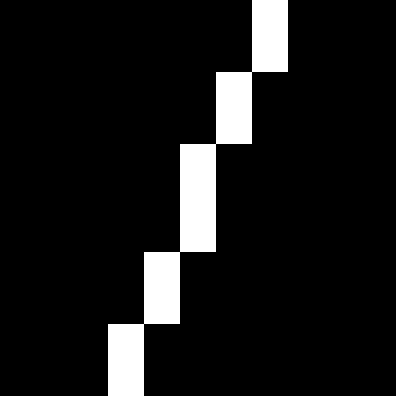
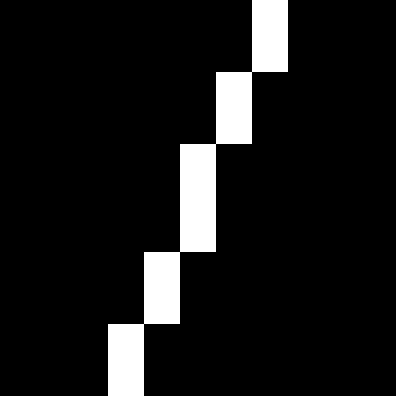
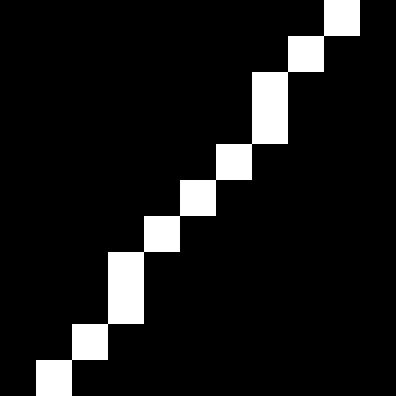
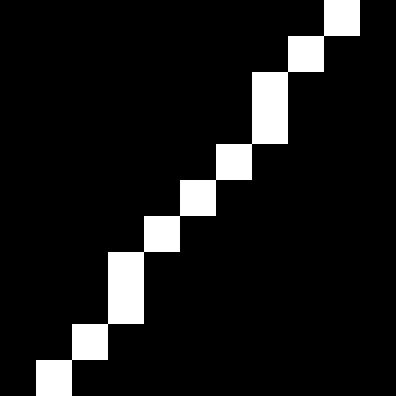
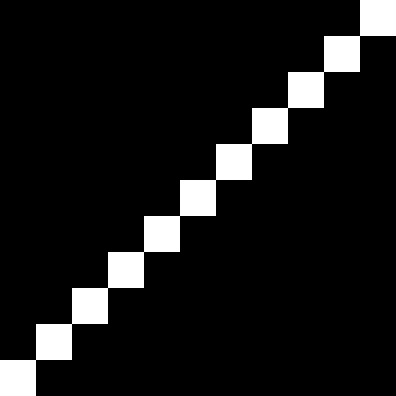
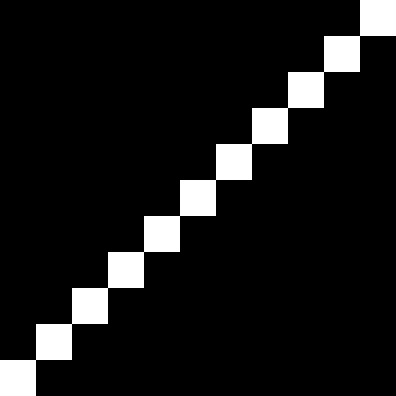
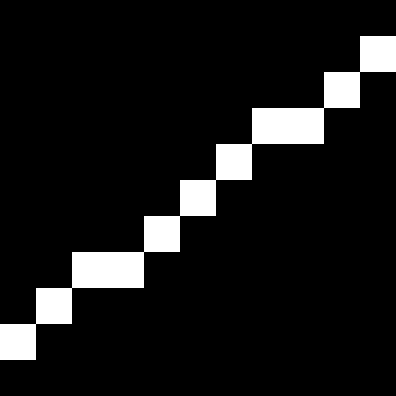
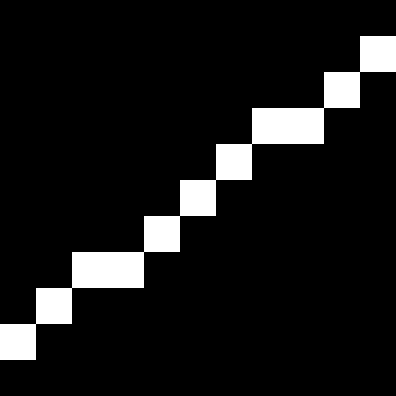
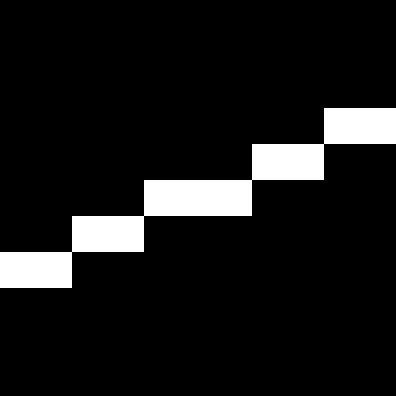
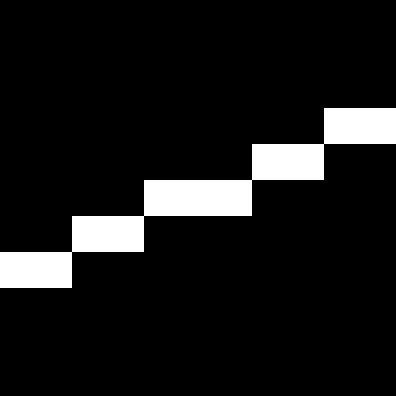
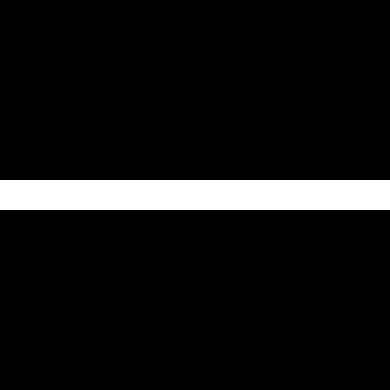
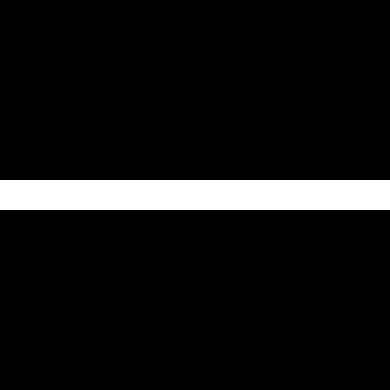
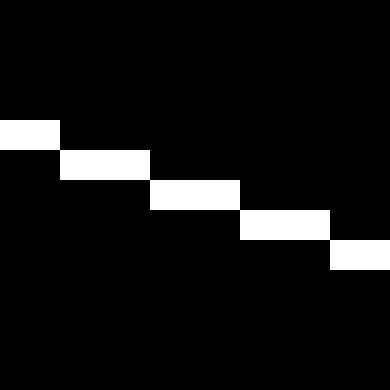
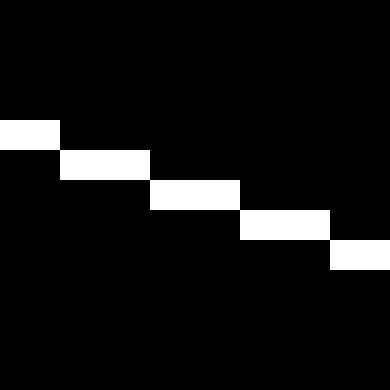
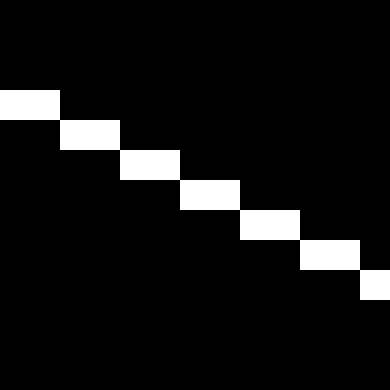
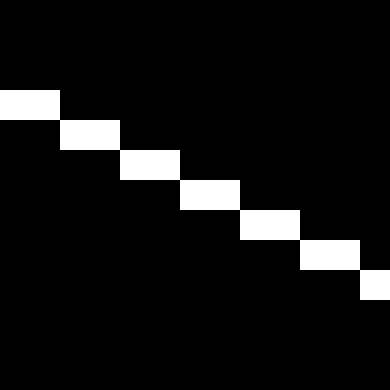
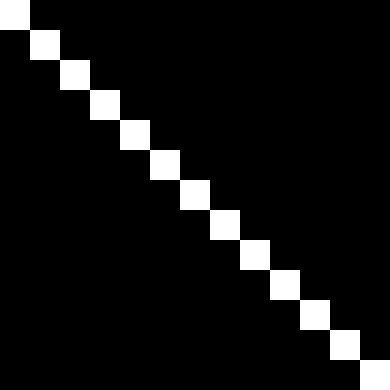
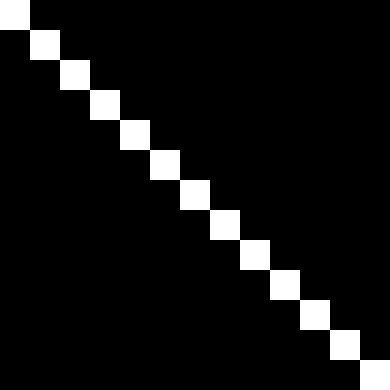
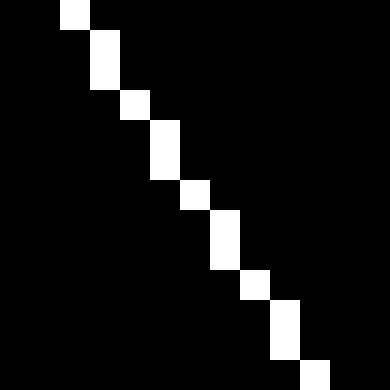
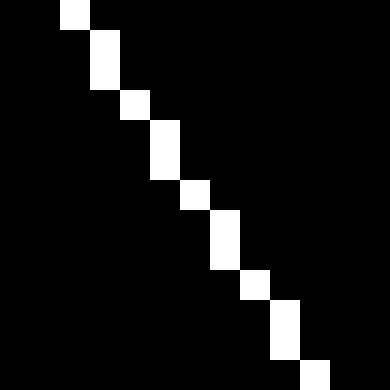
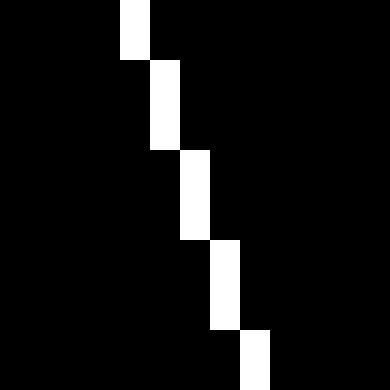
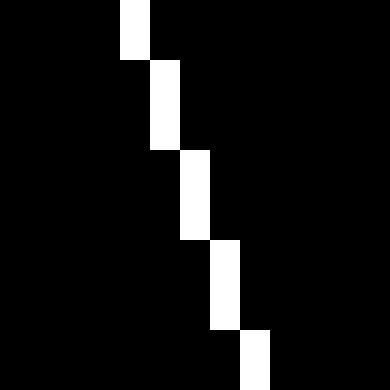
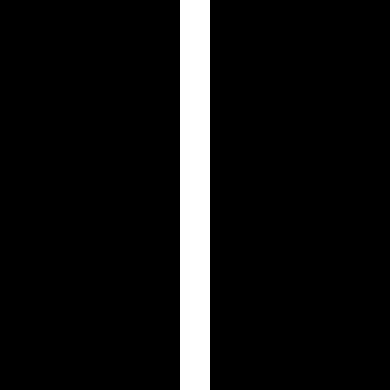
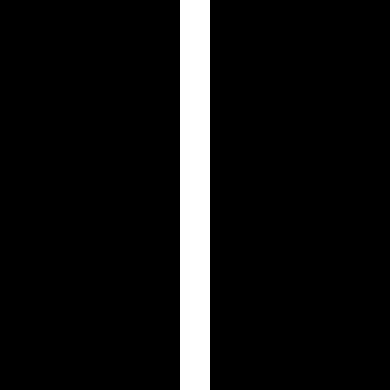
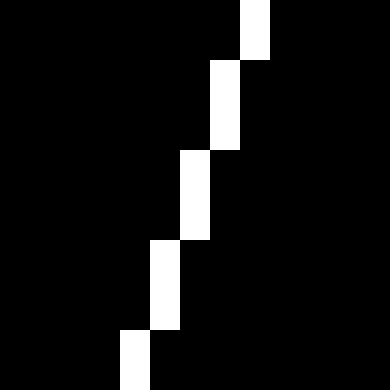
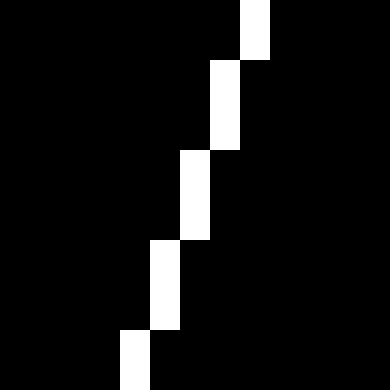
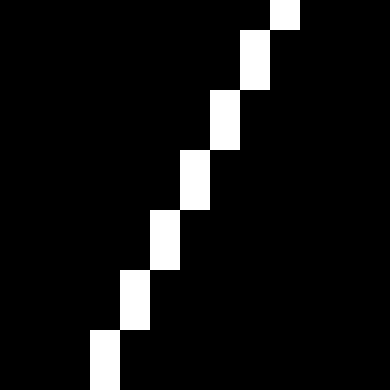
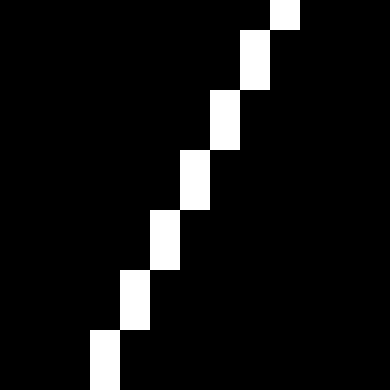
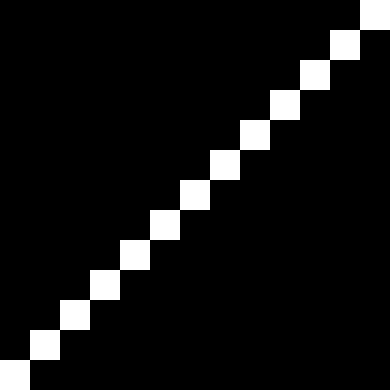
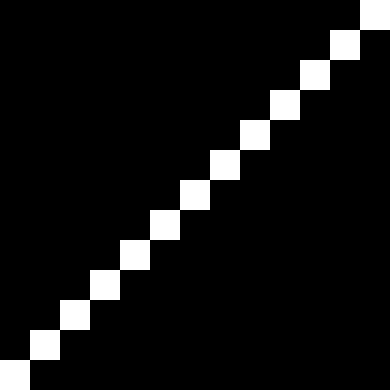
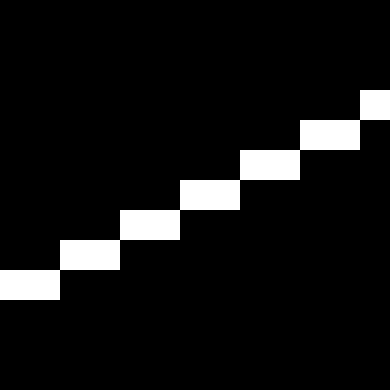
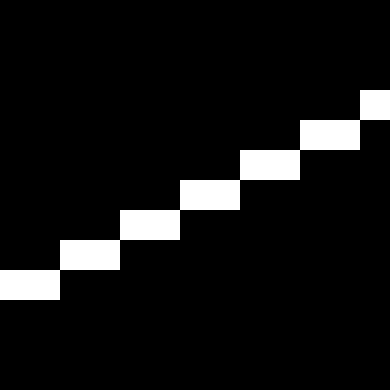
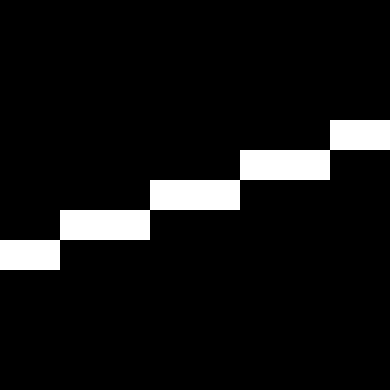
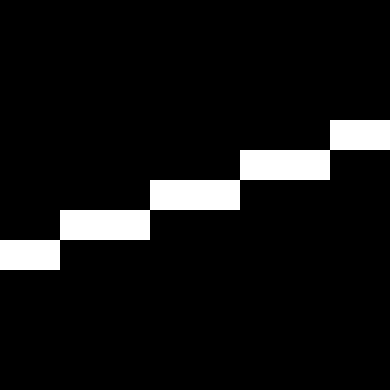

In [32]:
filters = [(create_motion_blur_filter(s, a), f's={s},a={a}°') for s in range(3,15,2) for a in range(0,180,15)]
filters_ok = np.load('filtri/motionblur.npy', allow_pickle=True)
merged = [x for f, f_ok in zip(filters, filters_ok) for x in [f, (f_ok, '(Verifica)')]]
va.show(*merged, max_per_row=12)

<img style="float:left" src="images/in.png" /> Se l'esercizio precedente è stato svolto correttamente, l'esecuzione della cella seguente consente verificarne in modo interattivo il funzionamento su alcune immagini.

In [33]:
@interact(image = ['thunderbirds.jpg', 'sphere.png', 'squares.png'], size=(3,99), angle=(0,179))
def motion_blur(image, size=7, angle=0):
    img = cv.imread('filtri/' + image)
    f = create_motion_blur_filter(size, angle)
    va.show(img, cv.filter2D(img, -1, f))
    

interactive(children=(Dropdown(description='image', options=('thunderbirds.jpg', 'sphere.png', 'squares.png'),…

Implementiamo ora una procedura che produca un effetto *emboss* su un'immagine. Si tratta di un effetto che simula rilievi e avvallamenti nell'immagine: i rilievi corrispondono alle parti più chiare e gli avvallamenti a quelle più scure.  
La procedura consiste nella conversione dell'immagine in grayscale, seguita da un blur gaussiano e dall'applicazione di un'apposito filtro.

<img style="float:left" src="images/ar.png" /><br/>**Esercizio 2** - 
Nella prossima cella completare la funzione `emboss` che deve eseguire le operazioni seguenti:
1. convertire `img` in scala di grigi;
2. applicare quindi un blur gaussiano con filtro quadrato di dimensione `blur_size` e parametro $\sigma$ determinato in automatico da OpenCV a partire dalla dimensione del filtro;
3. costruire un filtro quadrato con dimensione `emboss_size` i cui coefficienti devono valere: $F_{ij}=\left\{\begin{matrix}1&se\ i<j\\ 0&se\ i=j\\ -1&se\ i>j \end{matrix}\right.$;  
ad esempio, se `emboss_size`=3, il filtro deve essere: $F=\left[\begin{matrix}0&-1&-1\\ 1&0&-1\\ 1&1&0 \end{matrix}\right ]$;
4. applicare il filtro all'immagine ottenuta allo step 2 (senza ribaltarlo, ovvero mediante correlazione), memorizzando il risultato su un'immagine di interi con segno a 16 bit;
5. normalizzare il risultato facendo corrispondere il range dell'immagine [min,max] a [0,255];
6. restituire il risultato sotto forma di immagine di byte a un solo canale.

Suggerimenti: per costruire il filtro, fra i vari modi possibili, può essere interessante utilizzare la funzione NumPy `np.tri`. Per normalizzare l'immagine si può utilizzare, ad esempio, `cv.normalize` (nello stesso modo già visto a lezione per convertire l'immagine dei moduli del gradiente prima di visualizzarla).

In [36]:
def emboss(img, blur_size, emboss_size):
    
    # --- Svolgimento Esercizio 2: Inizio --- #
    
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  
    img_gray = cv.GaussianBlur(img, (blur_size,blur_size), 0)
                 
    f=np.tri(emboss_size, k=-1) - np.tri(emboss_size, k=-1).T
                
    res = cv.filter2D(img_gray, cv.CV_16S, f)
    
    res = cv.normalize(res, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U) 

    return res

    
    # --- Svolgimento Esercizio 2: Fine --- #

Eseguire la cella seguente per verificare la funzione `emboss` in alcuni casi di prova.

In [37]:
va.test_filtri_2(emboss)

ValueError: operands could not be broadcast together with shapes (221,445,3) (221,445) 

Iniziamo ora a fare un po' di pratica con l'estrazione dei bordi. Consideriamo l'immagine seguente:

![](filtri/fuji.jpg)

il bordo superiore della montagna, che separa la stessa dal cielo, è ben visibile. Vogliamo implementare una funzione che determini i pixel di tale bordo, in modo che siano il più connessi possibile (idealmente una linea continua da sinistra a destra dell'immagine). Vogliamo inoltre che non ci siano *falsi bordi* nella parte di immagine che contiene il cielo: questo fortunatamente non dovrebbe essere troppo difficile in quanto il cielo è molto uniforme, a parte qualche leggera nuvola nella parte destra. Il risultato in pratica dovrebbe essere qualcosa del genere:

![](filtri/fuji_edges.png)

<img style="float:left" src="images/ar.png" /><br/>**Esercizio 3** - 
Nella prossima cella completare la funzione `find_edges` che restituisca un'immagine binaria simile a quella appena vista. Nella cella seguente sarà possibile verificarne il funzionamento su alcune immagini di test: cercare di implementare la funzione in modo che il risultato sia ragionevolmente buono in tutti i casi. Per aiutare l'implementazione, come sempre è possibile creare nuove celle dove sperimentare varie possibilità: può essere anche utile ricorrere ad `@interact` per aggiustare i parametri dei metodi che si intendono applicare.

In [38]:
def find_edges(img):
    
    # --- Svolgimento Esercizio 3: Inizio --- #
    
    blurred = cv.GaussianBlur(cv.cvtColor(img, cv.COLOR_BGR2GRAY), (3, 3), 0)
    # Algoritmo di Canny con soglie t1 e t2
    edges = cv.Canny(blurred, 200, 100)
    #img_e = img.copy()
    img[edges!=0] = (0,255,255)
    
    # Resituisce un'immagine tutta a zero, solo a titolo di esempio
    return edges
    
    # --- Svolgimento Esercizio 3: Fine --- #

In [39]:
test_images = ['fuji', 'cervino', 'uluru', 'goldengate']

@interact(image=test_images)
def test_find_edges(image):
    img = cv.imread(f'filtri/{image}.jpg')
    va.show(img, find_edges(img), max_per_row=1)

interactive(children=(Dropdown(description='image', options=('fuji', 'cervino', 'uluru', 'goldengate'), value=…

Ora, a partire da un'immagine dei bordi come quella restitua dalla funzione appena implementata, vogliamo ottenere, per ogni coordinata $x$ dell'immagine, la coordinata $y$ del bordo superiore, ossia quello che separa il cielo dal soggetto (il monte o il ponte a seconda dell'immagine di test).

<img style="float:left" src="images/ar.png" /><br/>**Esercizio 4** - 
Nella prossima cella completare la funzione `find_top_edge` che riceve un'immagine binaria di tutti gli edge e restituisce un'array NumPy monodimensionale contenente, per ogni posizione $x$, la coordinata $y$ del primo edge che si incontra dall'alto verso il basso. Nel caso non vi sia alcun edge in una certa colonna dell'immagine, restituire la coordinata $y$ dell'ultimo pixel in basso (in realtà questa situazione, per il tipo di immagini di test, se i bordi sono estratti correttamente, non dovrebbe capitare).  
Suggerimento: fra i vari modi per risolvere l'esercizio, uno piuttosto elegante consiste nello sfruttare la funzione NumPy `np.argmax`.  
**Facoltativo**: In alcune immagini il bordo può avere alcuni "salti" troppo bruschi dovuti a imprecisioni nella fase precedente di estrazione dei bordi. Ridurre il problema applicando un filtro mediano (lineare) all'array delle coordinate $y$: ricalcolare ogni coordinata *y* come valore mediano di un opportuno intorno (ad esempio 5 elementi, i 2 a sinistra, l'elemento stesso e i 2 a destra).  

In [44]:
def find_top_edge(edges):
    
    # --- Svolgimento Esercizio 4: Inizio --- #
    
    first = np.argmax(edges, 0)
    
    # Tutte coordinate y dell'ultimo pixel in basso, a titolo di esempio
    #h, w = edges.shape[:2]
    return first# np.full(w, h-1)
    
    # --- Svolgimento Esercizio 4: Fine --- #

Nella cella seguente sarà possibile verificare il funzionamento della funzione su alcune immagini di test.

In [45]:
@interact(image=test_images, color_sky=False)
def test_find_top_edge(image, color_sky):
    img = cv.imread(f'filtri/{image}.jpg')
    ypos = find_top_edge(find_edges(img))    
    for x in range(img.shape[1]):
        if color_sky:
            img[:ypos[x], x, 1] = 255        
        img[ypos[x]:ypos[x]+5, x] = (0,255,255)
    va.show(img)

interactive(children=(Dropdown(description='image', options=('fuji', 'cervino', 'uluru', 'goldengate'), value=…

Oltre alla posizione dei pixel di bordo che abbiamo individuato, vogliamo anche sapere l'orientazione del bordo in corrispondenza di ciascun pixel. A tal fine sappiamo che ci può essere utile calcolare l'orientazione del gradiente, in quanto l'orientazione del bordo è perpendicolare ad essa. Si deve però prestare particolare attenzione al verso degli angoli e alla loro periodicità: l'orientazione del gradiente è un angolo nell'intervallo $[0°,360°)$ e, se calcolato come abbiamo visto a lezione, il suo verso è orario. Sarà richiesto di ricavare l'orientazione corrispondente nell'intervallo $[-90°,90°)$, perpendicolare al gradiente, misurata in senso antiorario, come mostrato nelle figure seguenti, in cui $\theta$ è l'angolo del gradiente e $\alpha$ è la corrispondente orientazione del bordo da calcolare.

![](filtri/angoli1.png)
![](filtri/angoli2.png)

<img style="float:left" src="images/ar.png" /><br/>**Esercizio 5** - 
Nella prossima cella completare la funzione `find_orientations` che, data un'immagine a colori, deve convertirla in scala di grigi, applicare un blur gaussiano con filtro di dimensione 15x15, calcolare l'orientazione del gradiente in ciascun punto mediante opportuni filtri derivativi. La funzione deve restituire una matrice NumPy di `np.float32` contenente l'angolo, in gradi, che il bordo ortogonale al gradiente nel pixel corrispondente forma con l'asse $x$. Tale angolo  deve essere sempre contenuto nell'intervallo $[-90°,90°)$: valori positivi indicano un angolo misurato in senso antiorario, valori negativi in senso orario.  
Nella cella seguente sarà possibile verificarne il funzionamento su alcune immagini di test: i pixel nella zona del bordo individuato con la funzione implementata precedentemente saranno colorati in base all'angolo corrispondente restituito da `find_orientations`, utilizzando la LUT seguente.

![](filtri/lutorient.png)

In [66]:
def find_orientations(img):
    
    # --- Svolgimento Esercizio 5: Inizio --- #
    
    gimg = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    blurred = cv.GaussianBlur(gimg, (15,15), 0)
    
    dx, dy = cv.Sobel(img, cv.CV_32F, 1, 0), cv.Sobel(img, cv.CV_32F, 0, 1)
    
    ang = cv.phase(dx, dy, angleInDegrees=True)
    
    return (-ang % 180) -90#(-ang/2)-90
    
    # --- Svolgimento Esercizio 5: Fine --- #

In [67]:
@interact(image=test_images)
def test_find_orientations(image):
    img = cv.imread(f'filtri/{image}.jpg')
    ypos = find_top_edge(find_edges(img))
    a = find_orientations(img)
    # -90..90 --> [0..255]
    a256 = ((a+90)/180*255).round().astype(np.uint8)
    ac = cv.applyColorMap(a256, cv.COLORMAP_HSV)
    w = img.shape[1]
    angles = ac[ypos, np.arange(w)] # angoli lungo il bordo
    res = np.zeros_like(img)
    for x in range(w):
        img[ypos[x]:ypos[x]+5, x] = angles[x]
    va.show(img)

interactive(children=(Dropdown(description='image', options=('fuji', 'cervino', 'uluru', 'goldengate'), value=…

<img style="float:left" src="images/in.png" />Eseguendo la cella seguente, le funzioni implementate precedentemente sono utilizzate per far compiere una bella passeggiata a Luigi in vari paesaggi...  
Si noti che quest'ultimo esempio sfrutta anche altri concetti già visti a lezione: trasformazioni geometriche di immagini e  alpha blending.

In [68]:
luigi_a = cv.imread('filtri/luigi.png', cv.IMREAD_UNCHANGED) # incluslo il 4 canale (alpha)
wn, hn = 44, 54
bw, bh = hn, hn
sw, sh = wn+bw*2, hn+bh*2
step = 44
luigi = [cv.copyMakeBorder(luigi_a[:hn,x:x+wn],bh,bh,bw,bw,cv.BORDER_CONSTANT) for x in range(0,luigi_a.shape[1],step)]
stepx = 3

@interact(n=test_images)
def prepare_img(n):
    back = cv.imread(f'filtri/{n}.jpg')
    back_b = cv.copyMakeBorder(back, sh, sh, sw, sw, cv.BORDER_CONSTANT) # per semplicità aggiunge un bordo allo sfondo
    ypos = find_top_edge(find_edges(back))
    angles = find_orientations(back)
    cx, cy = sw//2, bh+hn-2
    w = back.shape[1]
    angles = angles[ypos, np.arange(w)] # angoli lungo il bordo
    
    @interact(x=(0,w-1, stepx))
    def put_sprite(x=0):
        img = back_b.copy()
        y, a = ypos[x], angles[x]
        rot = cv.getRotationMatrix2D((cx,cy), a, 1) # Centro di rotazione sotto i piedi di luigi
        sprite = luigi[-((x//stepx) % len(luigi))]
        rotated = cv.warpAffine(sprite, rot, None, borderMode=cv.BORDER_CONSTANT)
        # il punto (cx,cy) di rotated deve essere traslato nel punto (x,y) di img
        x1, x2 = sw+x-cx, sw+x+(sw-cx)
        y1, y2 = sh+y-cy, sh+y+(sh-cy)
        rotated_rgb = rotated[...,:3]
        rotated_alpha = (rotated[...,3:]/255)
        # alpha blend
        img[y1:y2,x1:x2] = img[y1:y2,x1:x2]*(1.0-rotated_alpha) + rotated_rgb*rotated_alpha
        va.show(img[sh:-sh,sw:-sh]) # visualizza senza il bordo

interactive(children=(Dropdown(description='n', options=('fuji', 'cervino', 'uluru', 'goldengate'), value='fuj…

Concludiamo l'esercitazione con un esercizio in cui, a partire da due immagini, costruiremo una immagine *ibrida* che *appare diversa se guardata da vicino o da lontano*.

Sappiamo già che nelle alte frequenze di un'immagine sono contenuti i piccoli dettagli (cambiamenti rapidi nei valori dei pixel, come i bordi), mentre nelle basse frequenze ci sono i cambiamenti graduali di illuminazione, sfumatore di colore, etc.  
Abbiamo inoltre già visto come un filtro gaussiano ci permette di ottenere le basse frequenze e come, sottraendo all'immagine originale il risultato del filtro gaussiano, possiamo ottenere le alte frequenze.

L'esercizio seguente consiste nel separare basse e alte frequenze di due immagini e sommare l'immagine delle basse frequenze di un'immagine con quella delle alte frequenze dell'altra. I risultati migliori si ottengono con parametri specifici del filtro gaussiano per ciascuna immagine, sarà necessario quindi fare qualche esperimento per trovare i parametri ottimali.

<img style="float:left" src="images/ar.png" /><br/>**Esercizio 6** - Nella prossima cella completare la funzione `create_hybrid_image` che, date due immagini `img1`, `img2` e due interi `s1`, `s2`, esegue i seguenti passi:
1. applica un filtro gaussiano con $\sigma=s1$ e un'opportuna dimensione, per ottenere un'immagine contenente le basse frequenze di `img1` (`img1_lo`), quindi sottrae il risultato da `img1` per ottenere un'immagine delle alte frequenze (`img1_hi`);
2. applica un filtro gaussiano con $\sigma=s2$ e un'opportuna dimensione, per ottenere un'immagine contenente le basse frequenze di `img2` (`img2_lo`), quindi sottrae il risultato da `img2` per ottenere un'immagine delle alte frequenze (`img2_hi`);
3. ottiene una nuova immagine `res` sommando le alte frequenze di `img1` alle basse di `img2`.

Suggerimenti:
- si ricorda che in `cv.GaussianBlur`, passando `None` al parametro `ksize`, la dimensione del filtro viene impostata in automatico a partire dal parametro $sigma$;
- attenzione al tipo di dati dei pixel delle immagini: mentre l'immagine delle basse frequenze può essere in byte (il risultato del filtro gaussiano normalizzato è nello stesso range dell'immagine di partenza), in quella delle alte frequenze, essendo il risultato di una differenza, dovrà essere intero con segno (ad es. `np.int16`);
- i pixel dell'immagine risultante dalla somma possono essere semplicemente convertiti in byte limitanto i valori nel range [0,255] con `np.clip`.

In [69]:
def create_hybrid_image(img1, img2, s1, s2):
    
    # --- Svolgimento Esercizio 6: Inizio --- #
    
    img1_lo = cv.GaussianBlur(img1, None, s1)
    img1_hi = img1 - img1_lo
    
    img2_lo = cv.GaussianBlur(img2, None, s2)
    img2_hi = img2 - img2_lo
    
    res = img1_hi + img2_lo
        
    # --- Svolgimento Esercizio 6: Fine --- #
    
    # Restituisce le immagini intermedie e il risultato
    return (img1_lo, img1_hi, img2_lo, img2_hi, res)

<img style="float:left" src="images/in.png" />Eseguendo la cella seguente, sarà possibile verificare il comportamento della funzione appena implementata e trovare i parametri opportuni per costruire una perfetta immagine ibrida.

In [70]:
img1 = cv.imread('filtri/howard.png')
img2 = cv.imread('filtri/einstein.png')

@interact(s1=(0.5,10,0.5), s2=(0.5,10,0.5))
def test_create_hybrid_image(s1=1, s2=4):  
    *ii, hi = create_hybrid_image(img1, img2, s1, s2)
    va.show(*zip(ii,('img1_lo', 'img1_hi', 'img2_lo', 'img2_hi')),                        
            *[cv.resize(hi, dsize=None, fx=s, fy=s) for s in (0.25,0.33,1,3)],
            enlarge_small_images=False, max_per_row=4)

interactive(children=(FloatSlider(value=1.0, description='s1', max=10.0, min=0.5, step=0.5), FloatSlider(value…